# Sto learning 


Spectral Graph ConvNets<br>
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering<br>
M Defferrard, X Bresson, P Vandergheynst<br>

DOC : https://docs.dgl.ai/en/latest/api/python/nn.pytorch.html?highlight=cheb#dgl.nn.pytorch.conv.ChebConv

In [13]:
import os
import sys
import time
import numpy as np

# -------------Torch-------------------
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# -------------Graph-------------------
import dgl
import networkx as nx
import matplotlib.pyplot as plt

# -------------Personal Files-------------------
import sys
sys.path.append("..")

import graphs, model, utils, laplacian, ninja
from utils import set_device
from laplacian import normalized_laplacian

# Autoreload
sys.path.insert(0, "lib/")
%load_ext autoreload
%autoreload 2

# GPU 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = set_device(verbose=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda not available


# MNIST

In [6]:
# Downloads the dataset if not found locally
from dataset import check_mnist_dataset_exists, datasampler, MNISTDataset_rand

_ = check_mnist_dataset_exists()

nb_selected_train_data = 640
nb_selected_test_data = 1024

train_data, train_labels, test_data, test_labels = datasampler(
    nb_selected_train_data, nb_selected_test_data
)

In [7]:
trainset = MNISTDataset_rand(train_data, train_labels)
testset = MNISTDataset_rand(test_data, test_labels)

## Convolution layer and classifier


In [8]:
from model import Classifier, SanityCheck

In [9]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label, signal).
    graphs, labels, signals = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels),  torch.stack(signals).view(-1)

# Debug section
Verifying all of the steps

-------------------- Network model --------------------
 Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=5, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=160, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)
L tensor(indices=tensor([[  0,   0,   0,  ..., 783, 783, 783],
                       [  0,   1,  28,  ..., 755, 782, 783]]),
       values=tensor([ 1.9984e-15, -5.0000e-01, -4.0825e-01,  ...,
                      -4.0825e-01, -4.0825e-01,  1.9984e-15]),
       size=(784, 784), nnz=3752, layout=torch.sparse_coo) size: 784 time 0.03787708282470703 



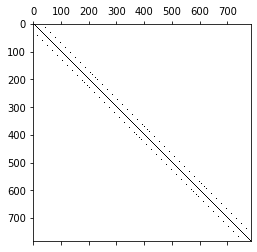

In [14]:
g, l, s = trainset[0]

# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 5
n_classes = trainset.num_classes

net2 = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
).to(device)
print("-------------------- Network model --------------------\n", net2)

t = time.time()
# Calculate L
g.to(device)
L = normalized_laplacian(g).to(device)
print("L", L, "size:", len(L), "time", time.time() - t,'\n')
plt.spy(L.cpu().to_dense())

In [15]:
print("\n --------------------  Output for graph g:  --------------------\n", net2(g, s, L))


 --------------------  Output for graph g:  --------------------
 tensor([[-0.0445,  0.0208,  0.0444, -0.0236, -0.0095,  0.0200,  0.0508, -0.0283,
          0.0055,  0.0958]], grad_fn=<AddmmBackward>)




# Model definition for training

In [16]:
# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = trainset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Training pipe

In [18]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=128,
                         shuffle=True, collate_fn=collate)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

epoch_losses = []

## Training time

In [21]:
from laplacian import normalized_laplacian
net.train()
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(5):
    epoch_loss = 0
    t0 = time.time()
    for iter, (bg, label, signal) in enumerate(data_loader):
        if iter == 0:
            L = normalized_laplacian(bg).to(device)
            #t = time.time()
            #print('\n THIS /!\ \n')
            #plt.imshow(signal.view(-1, 28), cmap='gray_r')

        if torch.cuda.is_available():
            bg.to(device)

        prediction = net(bg, signal, L)

        if iter == 0:
            #print("prediction time:", time.time() - t)
            t = time.time()
            print("One Prediction:\n", prediction[0], 'len:',
                  prediction.size(), '\n label:', label[0])  # DEBUG
        loss = loss_func(prediction, label.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach().item()

    epoch_loss /= iter + 1
    print(
        "Epoch {}, loss {:.4f}, in {:.2f}(s) ".format(
            epoch, epoch_loss, time.time() - t0
        )
    )
    epoch_losses.append(epoch_loss)

One Prediction:
 tensor([-0.0654, -0.4771,  0.1998, -0.5991, -0.3756,  0.0535,  0.0372, -0.4820,
         0.5244, -0.7498], grad_fn=<SelectBackward>) len: torch.Size([128, 10]) 
 label: tensor(8)
Epoch 0, loss 1.7348, in 81.20(s) 
One Prediction:
 tensor([-1.2059, -1.5352, -1.1486, -1.7174, -0.7340, -1.0167,  2.0549, -0.2113,
        -0.9503,  0.7119], grad_fn=<SelectBackward>) len: torch.Size([128, 10]) 
 label: tensor(6)
Epoch 1, loss 1.0584, in 87.64(s) 
One Prediction:
 tensor([ 1.6066, -4.5037, -0.0436, -3.7114,  0.4340, -1.5233,  5.6129,  0.5671,
        -2.5031, -0.2003], grad_fn=<SelectBackward>) len: torch.Size([128, 10]) 
 label: tensor(6)
Epoch 2, loss 0.6561, in 84.64(s) 
One Prediction:
 tensor([-4.4924, -0.4941, -0.9688, -1.5895,  3.8450, -0.9896, -0.1771, -0.6251,
        -1.1089,  0.9673], grad_fn=<SelectBackward>) len: torch.Size([128, 10]) 
 label: tensor(4)
Epoch 3, loss 0.5097, in 87.22(s) 
One Prediction:
 tensor([-1.6639, -0.9632, -0.7721,  0.2702, -0.8844,  4.179

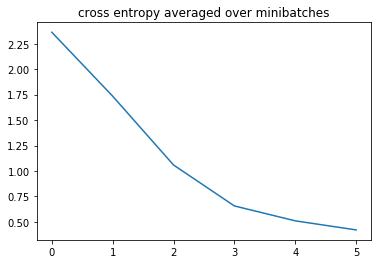

In [22]:
plt.title("cross entropy averaged over minibatches")
plt.plot(epoch_losses)
plt.show()

In [14]:
torch.cuda.empty_cache()

## Test Metrics

In [ ]:
# Change

net.eval()
# Convert a list of tuples to two lists
test_X, test_Y, test_S = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
print(test_bg)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
L = normalized_laplacian(test_bg)
test_S = torch.stack(test_S).view(-1)
probs_Y = torch.softmax(net(test_bg,test_S.to(device), L.to(device)), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print(
    "Accuracy of sampled predictions on the test set: {:.4f}%".format(
        (test_Y == sampled_Y.cpu().float()).sum().item() / len(test_Y) * 100
    )
)
print(
    "Accuracy of argmax predictions on the test set: {:4f}%".format(
        (test_Y == argmax_Y.cpu().float()).sum().item() / len(test_Y) * 100
    )
)

DGLGraph(num_nodes=802816, num_edges=2936088,
         ndata_schemes={}
         edata_schemes={})


In [ ]:
# BATCHED DGL EXAMPLE
import sklearn
from sklearn.metrics import classification_report

print(sklearn.metrics.classification_report(test_Y.cpu(), argmax_Y.cpu()))

## Saving

In [17]:
from utils import save_model

save_model("Model_6000_20ep_noooo", net)